# Emotion learning
Here we train an emotional encoder based on a dataset with RL trajectories from a previously trained RL agent.

## Dependencies

In [1]:
# The following code was run on Python 3.9.7

In [2]:
# Installation of libraries (in the specific versions used).
%pip install pandas==1.4.1
%pip install numpy==1.22.2
%pip install tensorflow==2.8.0
%pip install matplotlib==3.1.1
%pip install protobuf==3.19.4
%pip install keras==2.8.0

You should consider upgrading via the '/Users/Alberto/Code/love-emotional-framework/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/Alberto/Code/love-emotional-framework/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/Alberto/Code/love-emotional-framework/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/Alberto/Code/love-emotional-framework/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/Alberto/Code/love-emotional-framework/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the ke

In [3]:
# Enable automatic reloading of external modules before executing code here.
%load_ext autoreload
%autoreload 2

In [4]:
# Import packages.
import os
import sys
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import keras
from keras import layers, Sequential

In [5]:
# Import modules.
module_path = os.path.abspath(os.path.join('modules'))
if module_path not in sys.path:
    sys.path.append(module_path)

import time_series_tools as ts_tools

## Auxiliary code

In [33]:
def reset_random_seeds(seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

def plot_examples(x_orig, x_reg, n_samples=10, seed=0):
    n = 10  
    plt.figure(figsize=(20, 4))
    random.seed(seed)
    rnd_idx_list = [random.randint(0, len(x_orig) - 1) for _ in range(n_samples)]
    for i, idx in enumerate(rnd_idx_list):
        # display original
        ax = plt.subplot(2, n, i + 1)
        if i == 0:
            ax.set_ylabel("Input", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(x_orig[idx])
        ax.get_xaxis().set_visible(False)
        

        # display regeneration
        ax = plt.subplot(2, n, i + 1 + n)
        if i == 0:
            ax.set_ylabel("Output", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(x_reg[idx])
        ax.get_xaxis().set_visible(False)

## Training of the emotional encoder

### 1. Prepare dataset

#### Read dataset with Trajectories
* train_dataset
* test_dataset

In [18]:
# Paths to the lists with training / test trajectories to use.
path_to_trajectories = os.path.join(os.path.dirname(os.getcwd()), 'data', 'original', 'trajectories')
train_set_files_list_f = os.path.join(path_to_trajectories, 'train_set_files.txt')
test_set_files_list_f = os.path.join(path_to_trajectories, 'test_set_files.txt')
experiment_id = 'Exp-05.01'
columns = ['Step', 'Reward', 'Value']

with open(train_set_files_list_f) as f:
    train_set_list = f.readlines()
    train_set_list = [os.path.join(path_to_trajectories, line.rstrip()) for line in train_set_list]

with open(test_set_files_list_f) as f:
    test_set_list = f.readlines()
    test_set_list = [os.path.join(path_to_trajectories, line.rstrip()) for line in test_set_list]

train_dataset = ts_tools.read_all_trajectories_in_file_list(
    train_set_list,
    experiment_id=experiment_id,
    columns=columns
)
test_dataset = ts_tools.read_all_trajectories_in_file_list(
    test_set_list,
    experiment_id=experiment_id,
    columns=columns
)

print(len(train_dataset))
print(len(test_dataset))

48
12


In [19]:
# Take a look at one trajectory.
print(train_dataset[0])
train_dataset[0].plot(plot_width=800, plot_height=400)

Exp-05.01 (episode_8.txt)
     Step      Reward      Value
0       0    0.000000  68.482445
1       1   -0.805425  70.415993
2       2    0.178258  69.390709
3       3    3.428645  66.379517
4       4    2.729565  65.271263
..    ...         ...        ...
358   358   -0.000003  75.849434
359   359   -0.000001  75.849434
360   360    0.000001  75.849434
361   361    0.000002  75.849426
362   362  100.000000   0.000000

[363 rows x 3 columns]


#### Normalize the Trajectories
* norm_train_dataset
* norm_test_dataset

In [20]:
# NOTES:
# 1. Keep means and std.dev to rescale normalized model outputs.
# 2. Normalize test-set with train-set stats (to prevent test-set leakage).

norm_train_dataset, mean_dict, std_dict = ts_tools.z_score_normalize_trajectory_list(train_dataset)
norm_test_dataset, _, _ = ts_tools.z_score_normalize_trajectory_list(test_dataset, mean_dict, std_dict)

In [21]:
# Take a look at a normalized trajectory.
norm_train_dataset[0].plot(plot_width=800, plot_height=400)

#### Create a list of normalized sequences for training
Shape = (None, 20, 2)
* norm_train_seqs
* norm_test_seqs

In [22]:
columns = ['Reward', 'Value']
encoding_window = 20

random_seed = 9
reset_random_seeds(random_seed)

norm_train_seqs = ts_tools.create_sequences_from_trajectory_list(norm_train_dataset, encoding_window, columns=columns)
norm_test_seqs = ts_tools.create_sequences_from_trajectory_list(norm_test_dataset, encoding_window, columns=columns)
print(len(norm_train_seqs))
print(len(norm_test_seqs))

train_seqs = ts_tools.create_sequences_from_trajectory_list(train_dataset, encoding_window, columns=columns)
test_seqs = ts_tools.create_sequences_from_trajectory_list(test_dataset, encoding_window, columns=columns)


16281
3939


In [23]:
norm_train_seqs[0].shape

(20, 2)

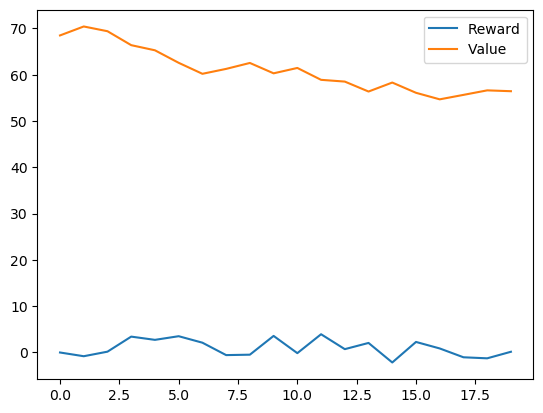

In [24]:
# Take a look at a non-normalized sequence.
train_seqs[0].plot()

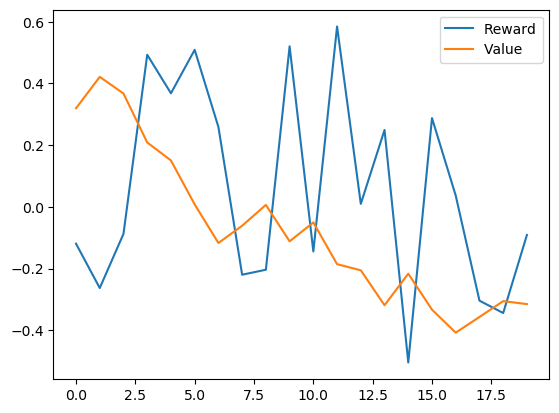

In [25]:
# Take a look at a normalized sequence.
norm_train_seqs[0].plot()

### 2. Define and train model

In [26]:
x_train = np.array(norm_train_seqs)
x_test = np.array(norm_test_seqs)
print(x_train.shape)
print(x_test.shape)

(16281, 20, 2)
(3939, 20, 2)


##### Training

In [27]:
# Hyperparameters
encoding_dim = 5

l1_filters = 32
l1_kernel_size = 5
l1_strides = 2

l2_filters = 16
l2_kernel_size = 5
l2_strides = 2

padding = 'same'
activation = 'relu'

random_seed = 9
reset_random_seeds(random_seed)

# Dimension of the Dense layer in the decoder depends on these:
decoder_dense_dim = int(x_train.shape[1] / (l1_strides * l2_strides))

In [28]:
conv_1d_encoder_b = Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),  # -> (None, 20, 2)
        layers.Conv1D(
            filters=l1_filters, kernel_size=l1_kernel_size, padding="same",  # -> (None, 10, 32)
            strides=l1_strides, activation="relu"
        ),
        layers.Conv1D(
            filters=l2_filters, kernel_size=l2_kernel_size, padding="same",  # -> (None, 5, 16)
            strides=l2_strides, activation="relu"
        ),
        layers.Flatten(),  # -> (None, 5 * 16)
        layers.Dense(encoding_dim, activation='relu'),  # -> (None, 5)
    ]
)
conv_1d_decoder_b = Sequential(
    [
        layers.Input(shape=(encoding_dim)),  # -> (None, 5)
        layers.Dense(decoder_dense_dim * l2_filters, activation='relu'),  # -> (None, 5 * 16)
        layers.Reshape((decoder_dense_dim, l2_filters)),  # -> (None, 5, 16)
        layers.Conv1DTranspose(
            filters=l2_filters, kernel_size=l2_kernel_size, padding="same",  # -> (None, 10, 16)
            strides=l2_strides, activation="relu",
        ),
        layers.Conv1DTranspose(
            filters=l1_filters, kernel_size=l1_kernel_size, padding="same",  # -> (None, 20, 32)
            strides=l1_strides, activation="relu"
        ),
        layers.Conv1DTranspose(filters=x_train.shape[2], kernel_size=5, padding="same"), # -> (None, 20, 2)
    ]
)
conv_1d_model_b = Sequential([conv_1d_encoder_b, conv_1d_decoder_b])

2024-02-18 17:03:58.445014: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [29]:
conv_1d_model_b.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
conv_1d_model_b.build((None, x_train.shape[1], x_train.shape[2]))  #(None, 20, 2)
conv_1d_encoder_b.summary()
conv_1d_decoder_b.summary()
conv_1d_model_b.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 32)            352       
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 16)             2576      
                                                                 
 flatten (Flatten)           (None, 80)                0         
                                                                 
 dense (Dense)               (None, 5)                 405       
                                                                 
Total params: 3,333
Trainable params: 3,333
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (No

In [30]:
history_b = conv_1d_model_b.fit(
    x_train, x_train,
    epochs=50,
    batch_size=10,
    validation_split=0.1,
    callbacks=[
    	keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
1466/1466 [==============================] - 5s 3ms/step - loss: 0.2603 - val_loss: 0.1660
Epoch 2/50
1466/1466 [==============================] - 3s 2ms/step - loss: 0.2199 - val_loss: 0.1472
Epoch 3/50
1466/1466 [==============================] - 4s 3ms/step - loss: 0.2045 - val_loss: 0.1376
Epoch 4/50
1466/1466 [==============================] - 3s 2ms/step - loss: 0.1994 - val_loss: 0.1298
Epoch 5/50
1466/1466 [==============================] - 3s 2ms/step - loss: 0.1889 - val_loss: 0.1266
Epoch 6/50
1466/1466 [==============================] - 4s 3ms/step - loss: 0.1868 - val_loss: 0.1262
Epoch 7/50
1466/1466 [==============================] - 4s 3ms/step - loss: 0.1859 - val_loss: 0.1246
Epoch 8/50
1466/1466 [==============================] - 4s 2ms/step - loss: 0.1842 - val_loss: 0.1230
Epoch 9/50
1466/1466 [==============================] - 4s 2ms/step - loss: 0.1833 - val_loss: 0.1221
Epoch 10/50
1466/1466 [==============================] - 4s 2ms/step - loss: 0.181

##### Model metrics

In [32]:
x_test_pred_b = conv_1d_model_b.predict(x_test)

Check regeneration (normalized values)

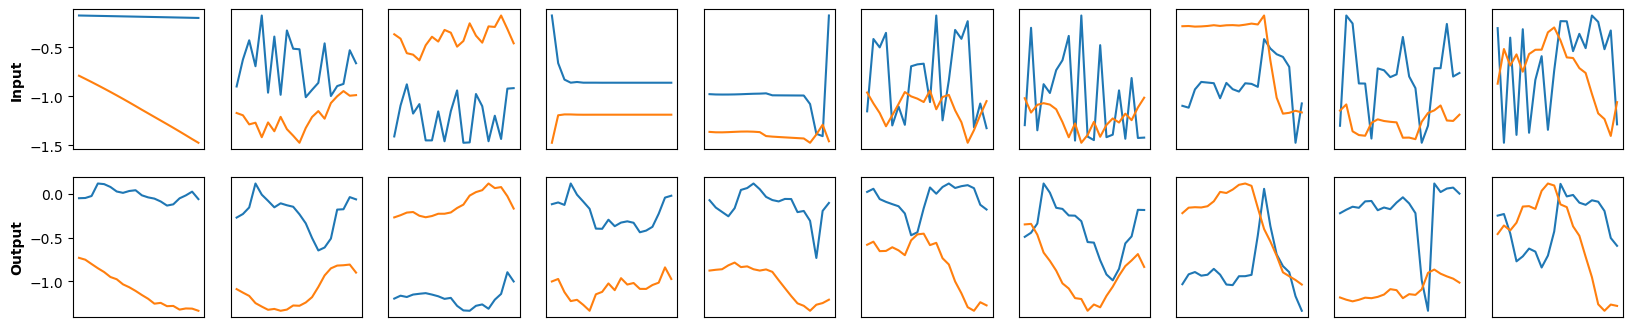

In [34]:
plot_examples(x_test, x_test_pred_b, seed=0)

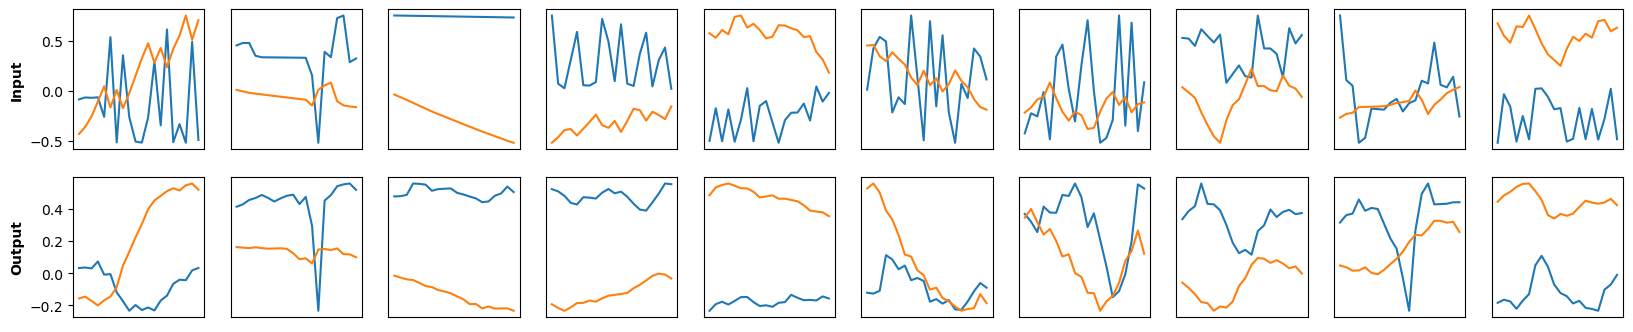

In [35]:
plot_examples(x_test, x_test_pred_b, seed=1)

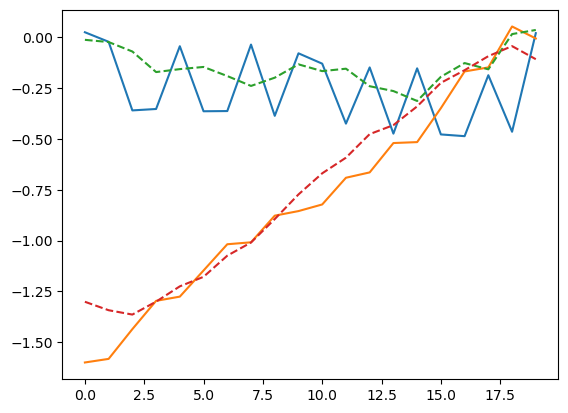

In [36]:
sample_idx = 10

plt.plot(x_test[sample_idx])
plt.plot(x_test_pred_b[sample_idx], linestyle='dashed')
plt.show()

Get metrics (unnormalized values)

In [37]:
mean_list = [mean_dict[c] for c in columns]
std_list = [std_dict[c] for c in columns]

x_test_regenerated = ts_tools.invert_normalization_of_sample_list(x_test_pred_b, mean_list, std_list)  # list of np.ndarray
reg_seqs = [pd.DataFrame(x, columns=columns) for x in x_test_regenerated]

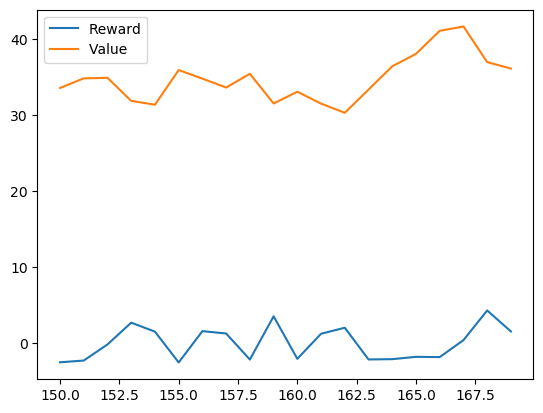

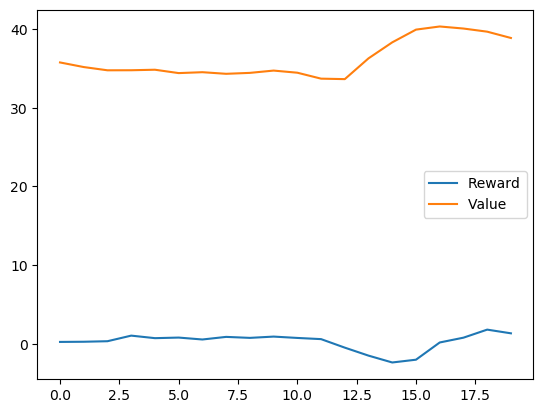

In [38]:
s = 400
test_seqs[s].plot()
reg_seqs[s].plot()

In [39]:
mae, mse, rmse = ts_tools.calculate_prediction_errors_of_list(test_seqs, reg_seqs, verbose=True)

             MAE        MSE      RMSE
Reward  2.119717   9.752419  3.122886
Value   2.994652  22.020405  4.692590


### 3. Save model

In [40]:
conv_1d_model = conv_1d_model_b
conv_1d_encoder = conv_1d_encoder_b
conv_1d_decoder = conv_1d_decoder_b

In [42]:
output_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'new_runs')
output_path


'/Users/Alberto/Code/love-emotional-framework/data/new_runs'

In [43]:
# Save the model
output_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'new_runs')
model_name = 'conv_1d_model_06'

conv_1d_model.save(os.path.join(output_path, f'{model_name}'))
conv_1d_encoder.save(os.path.join(output_path, f'{model_name}_encoder'))
conv_1d_decoder.save(os.path.join(output_path, f'{model_name}_decoder'))

2024-02-18 17:16:10.575644: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /Users/Alberto/Code/love-emotional-framework/data/new_runs/conv_1d_model_06/assets
INFO:tensorflow:Assets written to: /Users/Alberto/Code/love-emotional-framework/data/new_runs/conv_1d_model_06_encoder/assets
INFO:tensorflow:Assets written to: /Users/Alberto/Code/love-emotional-framework/data/new_runs/conv_1d_model_06_decoder/assets


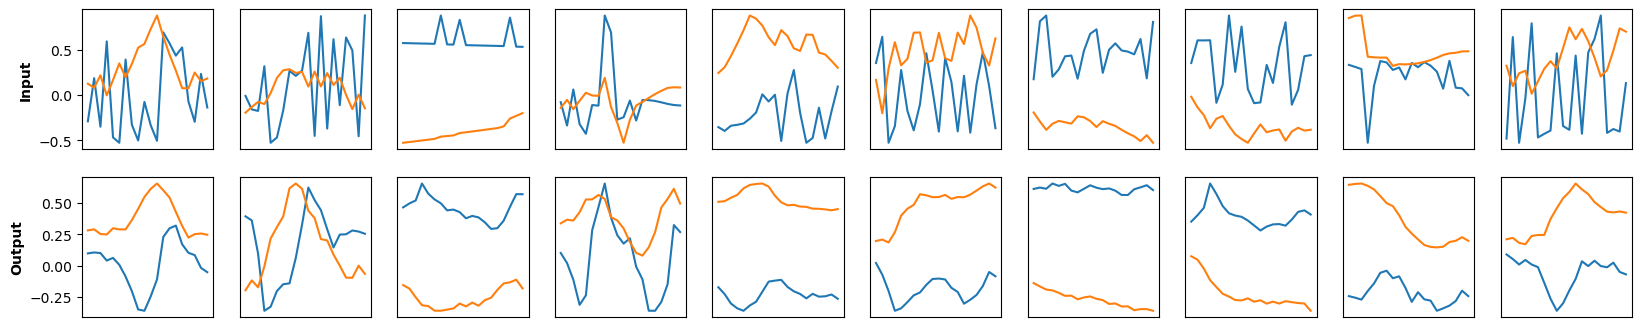

In [44]:
# Reload and test the model a bit.
loaded_model = keras.models.load_model(os.path.join(output_path, f'{model_name}'))
x_test_pred_after = loaded_model.predict(x_test)
plot_examples(x_test, x_test_pred_after, seed=23)